In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
N_FACE = 70
N_POSE = 8

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import time
import csv

Reshape Data into Segments and Prepare for Keras (part5 data)

In [2]:
train_path = './drive/My Drive/636/dataset/part6/trainset.csv'
trainset = pd.read_csv(train_path, index_col=0)
test_path = './drive/My Drive/636/dataset/part6/testset.csv'
testset = pd.read_csv(test_path, index_col=0)

NameError: ignored

In [3]:
127308 + 22325

149633

In [0]:
print(trainset.shape, testset.shape)

(127308, 158) (22325, 158)


In [0]:
# get number of features
N_FEATURES = (N_FACE + N_POSE) * 2

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, index_arr, TIME_STEP):
  slices = []
  for i in index_arr:
    if i + 1 < TIME_STEP:
      slice_ = df.values[df.index[0 : i + 1]]
      fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
      slice_ = np.concatenate((slice_, fillzero), axis=0)
      slices.append(slice_)
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  return slices_arr

In [0]:
def create_segments(df, TIME_STEP):
  # get video id
  vids = df.vid.unique()
  segments = []
  # get segment of each video id
  for i in vids:
    # slice every 10 frame as a segment and use the first label as label of segment
    # get all index of an id
    index_arr = df.index[df['vid'] == i]
    # drop the id and label
    df_s = df[df.columns[2:]]

    if i == vids[0]:
      segments = get_slices(df_s, index_arr, TIME_STEP)
    else:
      # get slices of each person
      segment = get_slices(df_s, index_arr, TIME_STEP)
      # print(i, segment.shape)
      segments = np.concatenate((segments, segment), axis=0)

  return segments

In [0]:
X_train = create_segments(trainset, 10)
X_test = create_segments(testset, 10)

In [0]:
y_train = trainset['label'].to_numpy()
y_test = testset['label'].to_numpy()

In [0]:
idx = np.random.permutation(y_train.shape[0])
X_train, y_train = X_train[idx], y_train[idx]

Build model

In [0]:
%tensorflow_version 1.x
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import History, EarlyStopping

In [0]:
# draw
import matplotlib.pyplot as plt
def draw(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

Model 4

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 64
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
def create_model_4():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                   input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [0]:
# create model
model = create_model_4()
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 9, 64)             20032     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 50)                12850     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 32,933
Trainable params: 32,933
Non-trainable params: 0
_________________________________________________________________
Train on 108211 samples, validate on 19097 samples
Epoch 1/100
 - 6s - loss: 1.6029 - acc: 0.6555 - val_loss: 0.662

In [0]:
print("test loss: ", score[0], "test acc: ", score[1])

test loss:  6.222380957321367 test acc:  0.6307726502418518


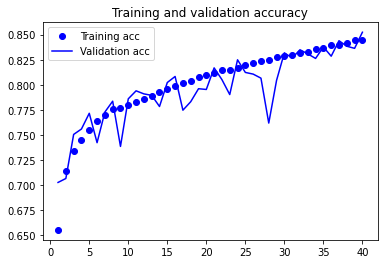

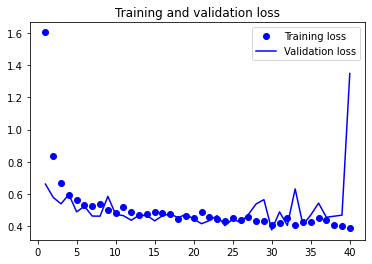

In [0]:
draw(history)

In [0]:
model.save('./drive/My Drive/636/model/model4_63.csv')

In [0]:
print("test loss: ", score[0], "test acc: ", score[1])

test loss:  2.9137049043930654 test acc:  0.7288689613342285


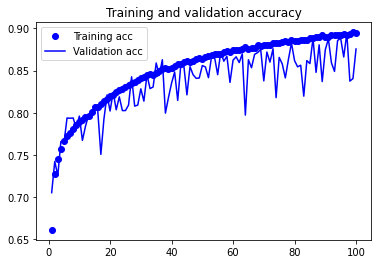

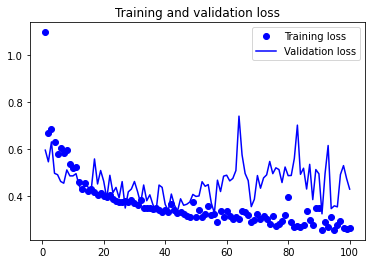

In [0]:
draw(history)

model 5

In [0]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

def create_model_5():
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu'), 
                            input_shape=(None, TIME_STEP, INPUT_DIM)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=4)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [0]:
X_train = X_train.reshape((X_train.shape[0], 1, TIME_STEP, INPUT_DIM))
model = create_model_5()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_25 (TimeDis (None, None, 7, 128)      80000     
_________________________________________________________________
time_distributed_26 (TimeDis (None, None, 1, 128)      0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, None, 128)         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 129,473
Trainable params: 129,473
Non-trainable params: 0
_______________________________________________

In [0]:
history = model.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)

Train on 108211 samples, validate on 19097 samples
Epoch 1/100
 - 11s - loss: 1.7549 - acc: 0.6408 - val_loss: 0.6589 - val_acc: 0.6990
Epoch 2/100
 - 10s - loss: 0.9087 - acc: 0.6884 - val_loss: 0.7403 - val_acc: 0.6909
Epoch 3/100
 - 10s - loss: 0.9375 - acc: 0.6987 - val_loss: 2.1439 - val_acc: 0.7221
Epoch 4/100
 - 10s - loss: 0.9142 - acc: 0.7095 - val_loss: 3.4655 - val_acc: 0.6322
Epoch 5/100
 - 10s - loss: 1.0212 - acc: 0.7198 - val_loss: 0.8902 - val_acc: 0.7395
Epoch 6/100
 - 10s - loss: 0.9783 - acc: 0.7250 - val_loss: 0.7270 - val_acc: 0.7480
Epoch 7/100
 - 11s - loss: 1.0929 - acc: 0.7285 - val_loss: 0.6532 - val_acc: 0.7574
Epoch 8/100
 - 10s - loss: 1.3012 - acc: 0.7324 - val_loss: 6.5882 - val_acc: 0.7604
Epoch 9/100
 - 10s - loss: 1.1011 - acc: 0.7337 - val_loss: 0.7851 - val_acc: 0.7184
Epoch 10/100
 - 10s - loss: 1.0255 - acc: 0.7385 - val_loss: 0.6031 - val_acc: 0.7497
Epoch 11/100
 - 10s - loss: 1.1437 - acc: 0.7387 - val_loss: 0.9346 - val_acc: 0.7252
Epoch 12/100

In [0]:
X_test = X_test.reshape((X_test.shape[0], 1, TIME_STEP, INPUT_DIM))
score = model.evaluate(X_test, y_test)

22325/22325 [==============================] - 1s 54us/step


In [0]:
print("test loss: ", score[0], "test acc: ", score[1])

test loss:  3.1159457619166187 test acc:  0.5736618041992188


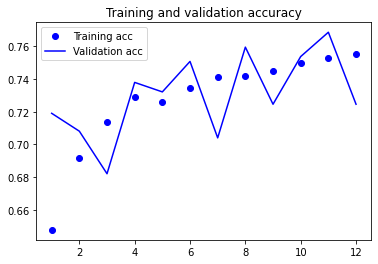

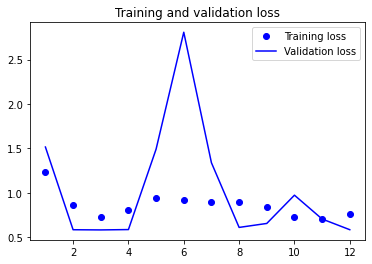

In [0]:
draw(history)

In [0]:
model.save('./drive/My Drive/636/model/model5_57.csv')

In [0]:
# X_train_r = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# y_train_r = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
# X_test_r = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# y_test_r = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
# model = create_model_6()
# history = model.fit(X_train_r, y_train_r, epochs=100, batch_size=50, 
#                     validation_split=0.15, verbose=2, callbacks=callbacks_list)
# score = model.evaluate(X_test_r, y_test_r)

In [0]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def create_model_6():
  model = Sequential()
  model.add(Dense(units = 100, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(LSTM(100, activation='relu', input_shape=(TIME_STEP, INPUT_DIM), 
                 return_sequences = True))
  model.add(Dropout(0.5))
  
  model.add(LSTM(100, activation='relu'))
  model.add(Dropout(0.5)) 
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]
model = create_model_6()
history = model.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 10, 100)           15700     
_________________________________________________________________
lstm_26 (LSTM)               (None, 10, 100)           80400     
_________________________________________________________________
dropout_20 (Dropout)         (None, 10, 100)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 101       
Total params: 176,601
Trainable params: 176,601
Non-trainable params: 0
_______________________________________________

In [0]:
print("test loss: ", score[0], "test acc: ", score[1])

test loss:  329.3636206848517 test acc:  0.6209630370140076


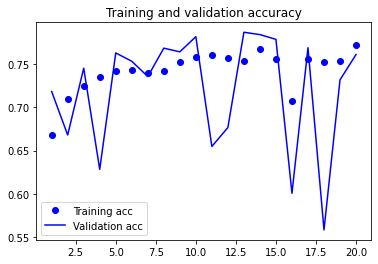

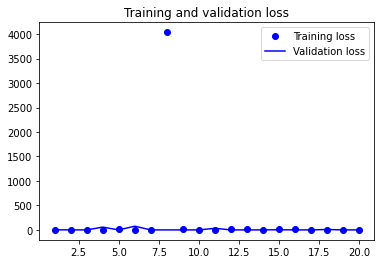

In [0]:
draw(history)

In [0]:
model.save('./drive/My Drive/636/model/model6_62.csv')